# How does COVID-19 affect the crime in Chicago, Illinois?

**Business Problem:**
Analyze the relationship between COVID-19 and its effects on types of crime, locations and frequencies of crime. Understand the patterns of crime that were taking place in Chicago and how they changed in relation to city shut-downs. 

 > **Used data sets:** 
 > - Chicago Covid-19 Data Set: [covid_clean](https://console.cloud.google.com/bigquery?project=ba775-project-291117&p=bigquery-public-data&d=covid19_open_data&t=covid19_open_data&page=table) (COVID-19 cases in Chicago since March 2020)
 > - Chicago Crime Data Set: [crime_clean](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2) (Crime Cases from 2001 to present)
 
 > **Steps in advance:**
 > - Cleaning the Data Sets: Covid-19 Set - deleted all null values in the date column and created a new DataFrame with the necessary Columns
 
 > **Restrictions and Limitations:**
 > - Chicago Crime Data Set: The addresses of the crimes are appromixated as part of the address is marked out with Xs, so analysis of different situations and zip codes are approximated over various areas. The data is directly reported about crimes by police, so data could be biased. Lastly, the dataset does not include a lot of boolean data therefore the regressions run have a lot of multicollinearity and it is hard to tell if particular variables are significant. 
 > - Chicago COVID-19 Data Set: The reporting date of the COVID-19 cases is not the date of catching the illness, and there is also the incubation period when the person may already be contagious but does not yet know that they have the virus. It is therefore possible that, especially with regard to the weekly comparison, there is a time lag that cannot be identified. COVID-19 data is limited because it only exists over 7 months.

# Executive Summary

The analysis of the different datasets has shown that a connection between COVID-19 and crimes in Chicago can indeed be established. In general, the following analysis shows that the crimes in 2020 are significantly lower compared to the crimes in 2019 (we decided to use 2019 because our previous analysis shows that the crime cases were consistent over the last 6 years). Especially in the months when the corona virus was new in the USA, the number of crimes decreased up to 69.7%. By comparing the number of different types of crimes in 2019 and 2020, we found that the top 5 crime types in 2019 and 2020 are the same. However, in 2020, the quantity of crimes in the top 5 crime types has dropped significantly, with theft dropping the most by 32.67%. The same thing occurred at the crime location. By comparing the number of crimes in different locations in 2019 and 2020, the number of crimes on sidewalks dropped the most by 33.10%. It should be noted that the analysis was not comprehensive enough to attribute the decline in crimes exclusively to the corona virus. In addition, arrested rates decreased due to COVID-19 because of the police strike and mitigation of the spread of COVID-19 in prisons. Lastly, while overall crime rates went down, we found that domestic violence overall increased by about 3% from 2019 to 2020.

## Approach:
1. Get an overview over each data set on its own
2. Clean and tidy the data
3. Ask multiple questions with Exploratory Data Analysis 
4. Understand and discuss the results
5. Figure out where to combine and what to compare between the different data sets
6. Formulate questions to answer
7. Answer the questions and analyze the results
8. Summary of the findings

### Overview Chicago Crime data set:
- **unique_key** - Case ID number.
- **date** - Date when the incident occurred. this is sometimes a best estimate.
- **primary_type** - The primary description of crime type.
- **description** - The secondary description of crime type, a subcategory of the primary description.
- **location_description** - Description of the location where the incident occurred.
- **arrest** - Indicates whether an arrest was made.
- **domestic** - Indicates incident was domestic-related as defined by the Illinois Domestic Violence Act.
- **district** - Indicates the police district where the incident occurred.
- **year** - Year the incident occurred.

### Necessary imports

In [623]:
import sys
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
pd.options.display.max_columns = None
from sklearn.linear_model import LinearRegression   
from numpy import genfromtxt
from sklearn import datasets,linear_model
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from scipy.stats import norm
import scipy.stats as stats

### Uncleaned Crime Data Set

In [561]:
crime = """
SELECT *
FROM `ba780-team8b.team8b.Chicago_crimes`
"""
crimes = client.query(crime).to_dataframe()

Because of the size of the dataset, no null-value will show in the crime.info().

In [562]:
display(crimes.head(),crimes.isnull().sum())

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,10640235,HZ392278,2016-08-14 21:51:00+00:00,045XX W MADISON ST,2093,NARCOTICS,FOUND SUSPECT NARCOTICS,ALLEY,True,False,1113,11.0,28.0,26.0,18,1146244.0,1899633.0,2016,2018-02-10 15:50:01+00:00,41.880575,-87.738469,"(41.880575249, -87.738469028)"
1,8363015,HT383349,2011-07-06 15:02:00+00:00,001XX S SPRINGFIELD AVE,2094,NARCOTICS,ATTEMPT POSSESSION CANNABIS,SIDEWALK,True,False,1122,11.0,28.0,26.0,18,1150408.0,1899296.0,2011,2016-02-04 06:33:39+00:00,41.879570,-87.723188,"(41.879570265, -87.72318787)"
2,11906423,JC528839,2019-11-29 18:56:00+00:00,007XX S KOSTNER AVE,502R,OTHER OFFENSE,VEHICLE TITLE/REG OFFENSE,STREET,True,False,1131,11.0,24.0,26.0,26,1147171.0,1896268.0,2019,2019-12-06 15:54:36+00:00,41.871324,-87.735151,"(41.871323609, -87.735151249)"
3,3893270,HL265721,2004-10-06 13:30:00+00:00,040XX W MADISON ST,1121,DECEPTIVE PRACTICE,COUNTERFEITING DOCUMENT,CURRENCY EXCHANGE,False,False,1115,11.0,28.0,26.0,10,1149562.0,1899708.0,2004,2018-02-28 15:56:25+00:00,41.880717,-87.726284,"(41.880717301, -87.72628358)"
4,4395742,HL673259,2005-10-14 18:00:00+00:00,040XX W LAKE ST,1210,DECEPTIVE PRACTICE,THEFT OF LABOR/SERVICES,CTA PLATFORM,True,False,1114,11.0,28.0,26.0,11,1149512.0,1901446.0,2005,2018-02-28 15:56:25+00:00,41.885488,-87.726422,"(41.885487535, -87.726422045)"


unique_key                   0
case_number                  4
date                         0
block                        0
iucr                         0
primary_type                 0
description                  0
location_description      7558
arrest                       0
domestic                     0
beat                         0
district                    47
ward                    614833
community_area          613484
fbi_code                     0
x_coordinate             84855
y_coordinate             84855
year                         0
updated_on                   0
latitude                 84855
longitude                84855
location                 84855
dtype: int64

### Cleaning the Data Set

We selected the columns that were relevant to our analysis.
We deleted the null values from **location_description** and **district** since they are a small portion of the dataset and will not affect our results.

In [563]:
crime_list = ['unique_key','date','primary_type','description','location_description','arrest','domestic','district','year']
crimes = crimes[crime_list]
clean1 = crimes[~crimes['location_description'].isna()]
crime_clean = clean1[~clean1['district'].isna()]
#display(crime_clean.head(),crime_clean.info())

### Aggregate similar primary_type ###

In [564]:
crime_types = {'NON-CRIMINAL':'NON-CRIMINAL', 'NON - CRIMINAL':'NON-CRIMINAL','NON-CRIMINAL (SUBJECT SPECIFIED)':'NON-CRIMINAL','CRIM SEXUAL ASSAULT':'CRIMINAL SEXUAL ASSAULT','CRIMINAL SEXUAL ASSAULT':'CRIMINAL SEXUAL ASSAULT',\
              'WEAPONS VIOLATION':'WEAPONS VIOLATION','CONCEALED CARRY LICENSE VIOLATION':'WEAPONS VIOLATION', 'NARCOTICS':'NARCOTIC VIOLATION','OTHER NARCOTIC VIOLATION':'NARCOTIC VIOLATION'}
crime_clean['primary_type'] = crime_clean['primary_type'].replace(crime_types)
# print(crime_clean['primary_type'].unique())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Selecting the month Jan-Oct to match the data for Covid-19

In [565]:
crime_clean = crime_clean[(crime_clean['date'].dt.month >=1) & (crime_clean['date'].dt.month <= 10)]
# crime_clean.head()

### Data Set with Crimes from 2019 and 2020

We decided to use this smaller data set to calculate the different questions we asked and we will use the whole data set for Machine Learning. The crime numbers are very similar over the last 5 years, therefore we decided that comparing just 2019 and 2020 crime rates will give us an accurate representation of the change in crime. 

In [566]:
#data only include 2019-2020 crime dataset
crime_1920 = crime_clean[(crime_clean['year']>=2019) & (crime_clean['year']<=2020)]
display(crime_1920.head(),crime_1920.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393959 entries, 8 to 7229328
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   unique_key            393959 non-null  int64              
 1   date                  393959 non-null  datetime64[ns, UTC]
 2   primary_type          393959 non-null  object             
 3   description           393959 non-null  object             
 4   location_description  393959 non-null  object             
 5   arrest                393959 non-null  bool               
 6   domestic              393959 non-null  bool               
 7   district              393959 non-null  float64            
 8   year                  393959 non-null  int64              
dtypes: bool(2), datetime64[ns, UTC](1), float64(1), int64(2), object(3)
memory usage: 24.8+ MB


,unique_key,date,primary_type,description,location_description,arrest,domestic,district,year
8,11819006,2019-09-06 08:02:00+00:00,OTHER OFFENSE,VIOLATION OF CIVIL NO CONTACT ORDER,STREET,False,True,11.0,2019
28,11648768,2019-04-07 09:00:00+00:00,BATTERY,AGGRAVATED DOMESTIC BATTERY: OTHER DANG WEAPON,APARTMENT,False,True,11.0,2019
41,12003472,2020-03-08 23:02:00+00:00,ASSAULT,"AGGRAVATED POLICE OFFICER - HANDS, FISTS, FEET...",STREET,True,False,11.0,2020
68,11604915,2019-02-23 18:50:00+00:00,NARCOTIC VIOLATION,SOLICIT NARCOTICS ON PUBLICWAY,SIDEWALK,True,False,11.0,2019
72,11991764,2020-02-22 16:40:00+00:00,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,RESIDENCE PORCH/HALLWAY,False,False,11.0,2020


None

### Overview Chicago COVID-19 data set:
- **Date** - Date when the COVID-19 reported.
- **Cases___Total** - Number of cases in the day.
- **Deaths___Total** - Number of deaths in the day.

### Uncleaned Covid-19 Data Set

In [568]:
covid = """
SELECT *
FROM `ba780-team8b.team8b.COVID-19_daily_chicago`
"""
covids = client.query(covid).to_dataframe()
display(covids.head(),covids.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 58 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Date                                       260 non-null    object 
 1   Cases___Total                              261 non-null    int64  
 2   Deaths___Total                             261 non-null    int64  
 3   Hospitalizations___Total                   256 non-null    float64
 4   Cases___Age_0_17                           261 non-null    int64  
 5   Cases___Age_18_29                          261 non-null    int64  
 6   Cases___Age_30_39                          261 non-null    int64  
 7   Cases___Age_40_49                          261 non-null    int64  
 8   Cases___Age_50_59                          261 non-null    int64  
 9   Cases___Age_60_69                          261 non-null    int64  
 10  Cases___Age_70_79         

,Date,Cases___Total,Deaths___Total,Hospitalizations___Total,Cases___Age_0_17,Cases___Age_18_29,Cases___Age_30_39,Cases___Age_40_49,Cases___Age_50_59,Cases___Age_60_69,Cases___Age_70_79,Cases____Age_80_,Cases___Age_Unknown,Cases___Female,Cases___Male,Cases___Unknown_Gender,Cases___Latinx,Cases___Asian_Non_Latinx,Cases___Black_Non_Latinx,Cases___White_Non_Latinx,Cases___Other_Race_Non_Latinx,Cases___Unknown_Race_Ethnicity,Deaths___Age_0_17,Deaths___Age_18_29,Deaths___Age_30_39,Deaths___Age_40_49,Deaths___Age_50_59,Deaths___Age_60_69,Deaths___Age_70_79,Deaths___Age_80_,Deaths___Age_Unknown,Deaths___Female,Deaths___Male,Deaths___Unknown_Gender,Deaths___Latinx,Deaths___Asian_Non_Latinx,Deaths___Black_Non_Latinx,Deaths___White_Non_Latinx,Deaths___Other_Race_Non_Latinx,Deaths___Unknown_Race_Ethnicity,Hospitalizations___Age_0_17,Hospitalizations___Age_18_29,Hospitalizations___Age_30_39,Hospitalizations___Age_40_49,Hospitalizations___Age_50_59,Hospitalizations___Age_60_69,Hospitalizations___Age_70_79,Hospitalizations___Age_80_,Hospitalizations___Age_Unknown,Hospitalizations___Female,Hospitalizations___Male,Hospitalizations___Unknown_Gender,Hospitalizations___Latinx,Hospitalizations___Asian_Non_Latinx,Hospitalizations___Black_Non_Latinx,Hospitalizations___White_Non_Latinx,Hospitalizations___Other_Race_Non_Latinx,Hospitalizations___Unknown_Race_Ethnicity
0,2020-03-01,0,0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1,2020-03-02,0,0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2020-03-03,0,0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,2020-03-04,0,0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0
4,2020-03-05,1,0,6.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0


None

### Cleaning the Covid-19 Data Set

We decided to just keep the necessary columns which are:
- Date
- Total Cases
- Total Death

We dropped all other columns to make the Dataframe easier to read and one missing value in **Date**.

In [569]:
covid_date = covids.dropna(subset=['Date'])

In [570]:
columns = ['Date', 'Cases___Total', 'Deaths___Total']
covid_clean = covid_date[columns]
display(covid_clean.head(),covid_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 0 to 260
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            260 non-null    object
 1   Cases___Total   260 non-null    int64 
 2   Deaths___Total  260 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.1+ KB


,Date,Cases___Total,Deaths___Total
0,2020-03-01,0,0
1,2020-03-02,0,0
2,2020-03-03,0,0
3,2020-03-04,0,0
4,2020-03-05,1,0


None

## Analyzing the correlation between Covid-19 cases and crime cases in Chicago:
The following query compares the monthly crime cases in 2019 to monthly crimes in 2020 *(January to October)* and compares these values to monthly COVID-19 cases in 2020 *(note: January and February are null because Chicago had no reported COVID cases in those months)*. In addition, the difference between the crimes in 2019 and crimes in 2020 per month is shown in percentages *(Diff Crimes 19/20)*. The data indicates a very strong increase in COVID-19 cases in October and the press is speaking of a 2nd wave.

In [571]:
#Converintg the date object into a date and loc it into a new colum called month for crimes and Covid
crime_1920.loc[:,'date'] = pd.to_datetime(crime_1920.date, format='%Y-%m-%d', utc = True)
crime_1920.loc[:,'month'] = crime_1920['date'].dt.month
crime_1920.loc[:,'week'] = crime_1920['date'].dt.isocalendar().week

covid_clean.loc[:,'Date'] = pd.to_datetime(covid_clean.Date, format='%Y-%m-%d', utc = True)
covid_clean.loc[:,'month'] = covid_clean['Date'].dt.month
covid_clean.loc[:,'week'] = covid_clean['Date'].dt.isocalendar().week

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [572]:
#Creating 3 new series with needed information for the next step (Join).
crime_19_month = crime_1920[(crime_1920['year']== 2019) & (crime_1920['month']>= 1) & (crime_1920['month']<= 10)]\
            .groupby(by='month')['year'].count()

crime_20_month = crime_1920[(crime_1920['year']== 2020) &(crime_1920['month']>= 1) & (crime_1920['month']<= 10)]\
            .groupby(by='month')['unique_key'].count()

crime_month_diff = (crime_20_month - crime_19_month)/crime_20_month*100

covid_month = covid_clean[(covid_clean['month']>= 1) & (covid_clean['month']<= 10)]\
            .groupby(by='month')['Cases___Total'].sum()


In [573]:
#Joining the 3 series with pd.concat and renaming the columns for more readability.
crime_vs_covid_m = pd.concat([covid_month, crime_19_month, crime_20_month, crime_month_diff], axis=1)
crime_vs_covid_m.columns = ['Covid-19 Cases', 'Crimes-Cases 19', 'Crimes-Cases 20', 'Diff Crimes 19/20']
crime_vs_covid_m

,Covid-19 Cases,Crimes-Cases 19,Crimes-Cases 20,Diff Crimes 19/20
month,,,,
1,NaN,19530,19596,0.336803
2,NaN,18281,17980,-1.674082
3,4414.0,20326,16436,-23.667559
4,21571.0,20890,12654,-65.086139
5,21354.0,23535,17317,-35.906912
6,6308.0,23469,17350,-35.268012
7,8272.0,24729,19239,-28.535787
8,9983.0,24282,19487,-24.606148
9,9156.0,22287,17449,-27.726517


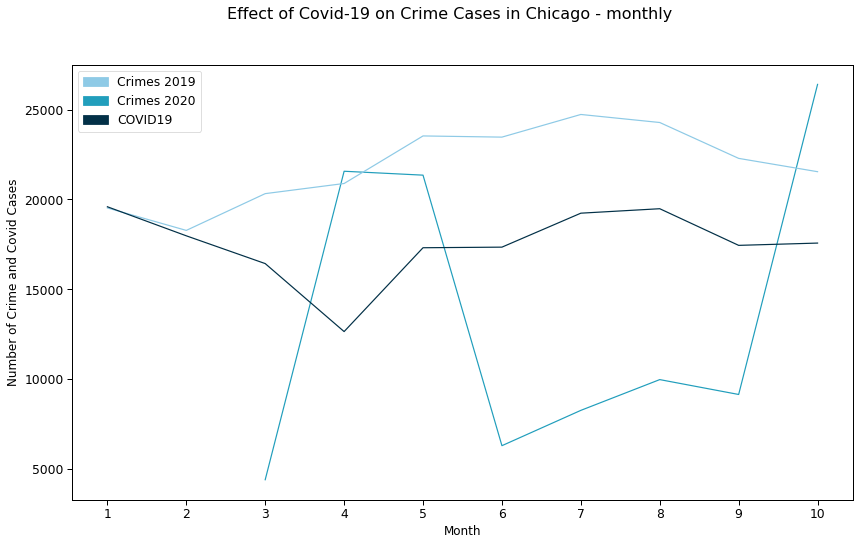

In [648]:
#Visualization
visual1 = crime_vs_covid_m[['Covid-19 Cases', 'Crimes-Cases 19', 'Crimes-Cases 20']]
hue_colors = {'#8ecae6','#219ebc','#023047'}
sns.set_palette(hue_colors)
plt.figure(figsize=(14, 8))
plt.plot(visual1)
plt.ylabel('Number of Crime and Covid Cases', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.suptitle('Effect of Covid-19 on Crime Cases in Chicago - monthly', fontsize=16)
plt.yscale('linear')
plt.xticks(range(1, 11))
patch1 = mpatches.Patch(color='#8ecae6', label='Crimes 2019')
patch2 = mpatches.Patch(color='#219ebc', label= 'Crimes 2020')
patch3 = mpatches.Patch(color='#023047', label= 'COVID19')
plt.legend(handles=[patch1, patch2, patch3]);

### Weekly comparsion:
This query compares the the same things mentioned in the query above just on a weekly basis. In addition this link provides the [restrictions](https://www.chicago.gov/city/en/sites/covid-19/home/health-orders.html) made by the city of Chicago.
Note that in week 13: Chicago city closed all parks, beaches, and some sports like soccer were not allowed anymore. COVID-19 cases still increased but crime cases decreased.
In week 22: there was a very high crime rate and relatively low corona cases.
In week 31 and 32: there was a significant crime increase within a week.
A statement in week 30 allowed businesses to open again - 2 weeks later there were more crimes but corona cases remained pretty stable.
Overall the crime rate significantly decreased since COVID-19, especially in the very beginning of COVID-19 *(see weeks 12 to 18)*. 

In [575]:
crime_19_week = crime_1920[(crime_1920['year']== 2019) & (crime_1920['week']>= 9) & (crime_1920['week']<= 44)]\
            .groupby(by='week')['year'].count()

crime_20_week = crime_1920[(crime_1920['year']== 2020) & (crime_1920['week']>= 9 ) & (crime_1920['week']<= 44)]\
            .groupby(by='week')['unique_key'].count()

crime_week_diff = (crime_20_week - crime_19_week)/crime_20_week*100

covid_week = covid_clean[(covid_clean['week']>= 1) & (covid_clean['week']<= 44)]\
            .groupby(by='week')['Cases___Total'].sum()

In [576]:
crime_vs_covid_w = pd.concat([covid_week, crime_19_week, crime_20_week, crime_week_diff], axis=1)
crime_vs_covid_w.columns = ['Covid-19 Cases', 'Crimes-Cases 19', 'Crimes-Cases 20', 'Diff Crimes 19/20']
crime_vs_covid_w.head()

,Covid-19 Cases,Crimes-Cases 19,Crimes-Cases 20,Diff Crimes 19/20
week,,,,
9,0,4373,4192,-4.317748
10,10,4256,4324,1.572618
11,152,4787,4186,-14.357382
12,968,4702,3368,-39.608076
13,2356,4639,3032,-53.001319


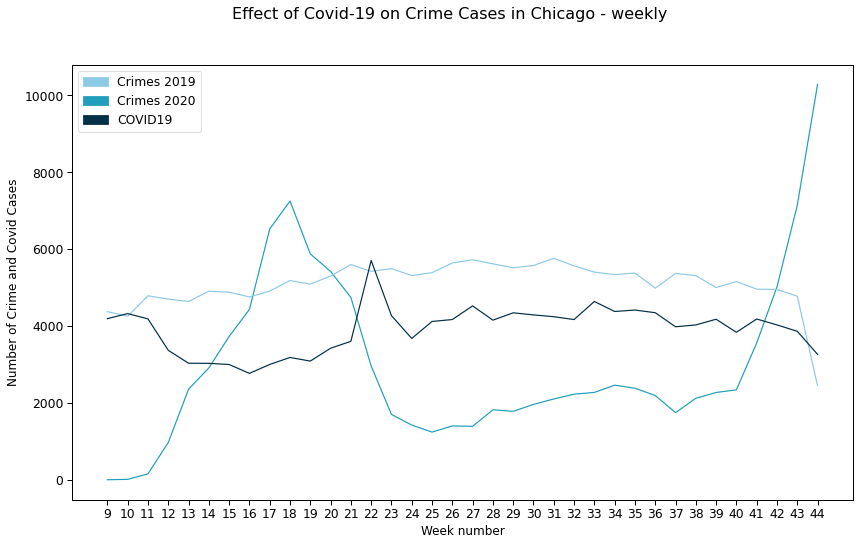

In [650]:
#Visualization
visual2 = crime_vs_covid_w[['Covid-19 Cases', 'Crimes-Cases 19', 'Crimes-Cases 20']]
hue_colors = {'#8ecae6','#219ebc','#023047'}
sns.set_palette(hue_colors)
plt.figure(figsize=(14, 8))
plt.plot(visual2)
plt.ylabel('Number of Crime and Covid Cases', fontsize=12, color = 'black')
plt.xlabel('Week number', fontsize=12, color = 'black')
plt.suptitle('Effect of Covid-19 on Crime Cases in Chicago - weekly', fontsize=16, color='black')
plt.yscale('linear')
plt.xticks(range(9, 45))
patch1 = mpatches.Patch(color='#8ecae6', label='Crimes 2019')
patch2 = mpatches.Patch(color='#219ebc', label= 'Crimes 2020')
patch3 = mpatches.Patch(color='#023047', label= 'COVID19')
plt.legend(handles=[patch1, patch2, patch3]);

### Linear regression Part One: 2020 CRIME and COVID
### 1-1. Simple Linear Regression: 2020 weekly crime cases vs. weekly covid cases
This regression mainly indicates that the relationship between Chicago weekly COVID cases and Chicago weekly crimes is negative. The relationship coefficient is -0.19686426. When COVID cases increase by 10, the expectation of Chicago crimes decreases by 1.9686426. When COVID cases increase by 20, the expectation of Chicago crimes decreases by 3.9372852.

coefficient matrix:
 [-0.19686426]
linear regression:
 LinearRegression(n_jobs=1)


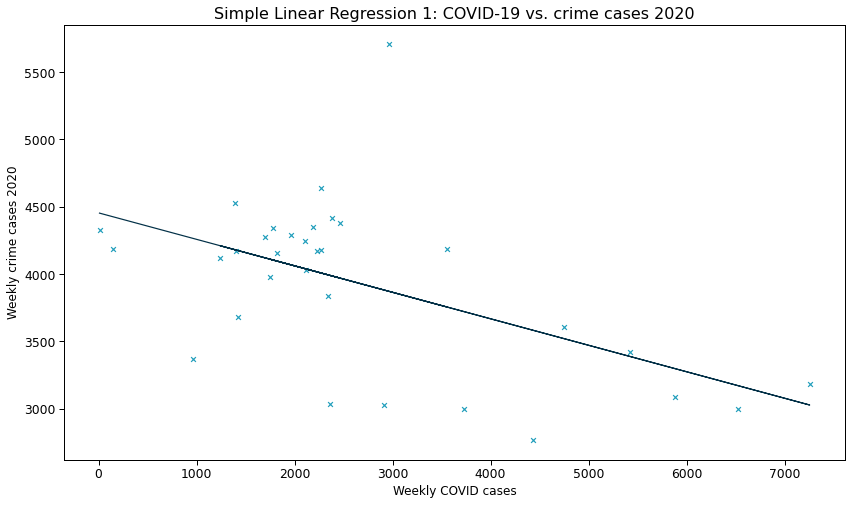

In [638]:
#Simple Linear Regression Visualization
data=pd.read_csv('780-project-machine-learning1.csv')
plt.figure(figsize=(14, 8)) 
dataMat = np.array(data)
X = dataMat[:,0:1]   
y = dataMat[:,1]
 
model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
model.fit(X, y)  
print('coefficient matrix:\n',model.coef_)
print('linear regression:\n',model)

predicted = model.predict(X)
 
plt.scatter(X, y, marker='x', c = '#219ebc')
plt.plot(X, predicted,c='#023047')

plt.title("Simple Linear Regression 1: COVID-19 vs. crime cases 2020",fontsize=16, color='black')
plt.xlabel("Weekly COVID cases",fontsize=12, color = 'black')
plt.ylabel("Weekly crime cases 2020",fontsize=12, color = 'black')
plt.show()

MSE: 750573.401
determinator: -3.505
prediction model is：y=-0.130x+3777.880


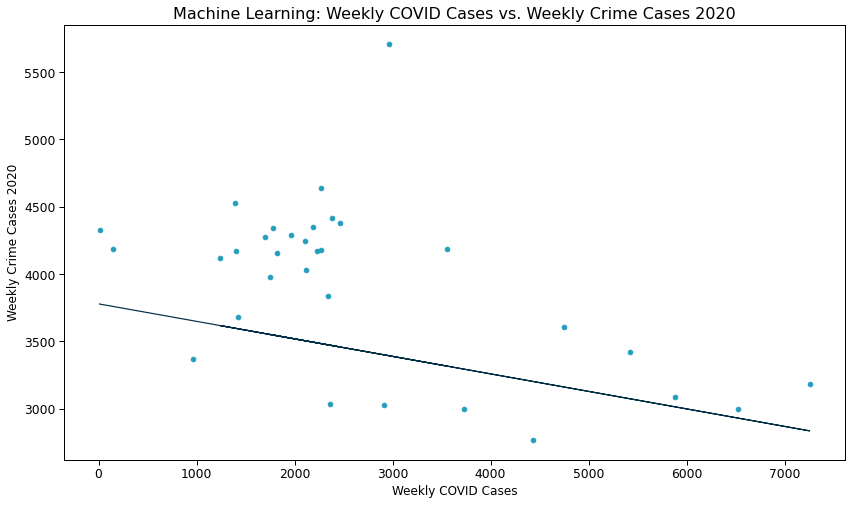

In [644]:
#Machine Learning: Weekly COVID Cases vs. Weekly Crime Cases 2020
def linearmodel(data):
	features=['x']
	labels=['y']
	train_data=data[:11]
	test_data=data[11:]
	model=train_model(train_data,features,labels)
	error,score=evaluate_model(model,test_data,features,labels)
	visualize_model(model,data,features,labels,error,score)

def train_model(train_data,features,labels):
	model=linear_model.LinearRegression()
	model.fit(train_data[features],train_data[labels])
	return model

def evaluate_model(model,test_data,features,labels):
	error=np.mean((model.predict(test_data[features])-test_data[labels])**2)
	score=model.score(test_data[features],test_data[labels])
	error=("%.3f" % error[0])
	print('MSE:',error) 
	score=("%.3f" % score)
	print('determinator:',score)
	coef=("%.3f" % model.coef_)
	intercept=("%.3f" % model.intercept_)
	if model.intercept_<0:
		print('prediction model is：y={}x{}'.format(str(coef),str(intercept)))
	else:
		print('prediction model is：y={}x+{}'.format(str(coef),str(intercept)))
	return error,score

def visualize_model(model,data,features,labels,error,score):
	fig=plt.figure(figsize=(14,8)) 
	ax=fig.add_subplot(111)
	ax.set_xlabel('Weekly COVID Cases',fontsize=12, color = 'black')
	ax.set_ylabel('Weekly Crime Cases 2020',fontsize=12, color = 'black')
	ax.set_title("Machine Learning: Weekly COVID Cases vs. Weekly Crime Cases 2020", fontsize=16, color='black')
	ax.scatter(data[features],data[labels],color='#219ebc')
	ax.plot(data[features],model.predict(data[features]),color='#023047')
	plt.show()

if __name__=='__main__':
	path='780-project-machine-learning1.csv'
	data=pd.read_csv(path)
	linearmodel(data)

### 1-2. Multivariate Regression: 2020 weekly crime cases vs. weekly covid cases & weekly arrest cases & shutdown
According to the regression output, 2020 weekly crime cases = -0.1042*weekly covid cases + 1166.7115*shutdown + 3.4775*weekly arrest cases + 1198.0755。
The relationship between independent variables and dependent variables in a multivariate regression are all captured by slope coefficients. You may also observe such linear relationships directly from observing pairplots below.

However, according to the correlation matrix below and the regression summary output generated by Python, the condition number is large, 2.58e+04. This might indicate that there is strong multicollinearity or other numerical problems. Given our datasets only include limited quantified or Boolean data categories that can interact with our dependent variable 2020 weekly crime cases, it's hard to get rid of the multicollinearity issue entirely. This is one limitation of the multivariate regression model. If we had a chance to collect the data by ourselves, we might have pre-determined the data categories that must be included in a multivariate regression, and we might have kept all the independent variables to be highly independent from each others.

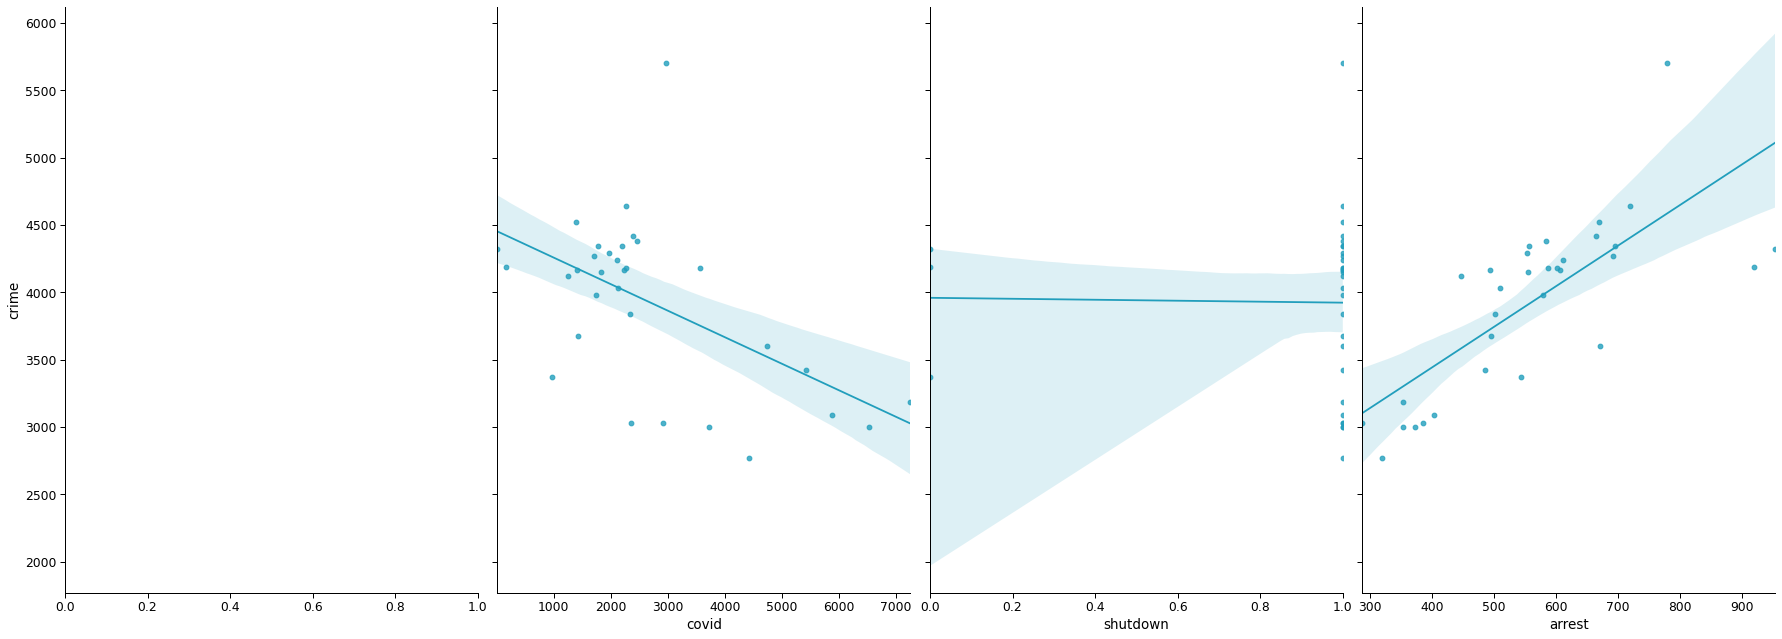

In [628]:
#plot individual regression lines to get the relationship between 2020 weekly crime and some individual variables
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df, x_vars=['','covid', 'shutdown','arrest'], y_vars='crime',kind="reg", height=9, aspect=0.7)
plt.show()

In [580]:
#Linear Multivariate Regression
dataPath = r"780-1129.csv"  
delivaryData = np.genfromtxt(dataPath,delimiter=',')  

X = delivaryData[:,:-1]  
Y = delivaryData[:,-1]

regr = linear_model.LinearRegression()  

regr.fit(X,Y) 

print("xs' coefficients：",regr.coef_)   
print("intercept：",regr.intercept_) 

xs' coefficients： [-1.04199854e-01  1.16671154e+03  3.47745009e+00]
intercept： 1198.0754716270317


In [581]:
#Logistic Multivariate Regression
df=pd.read_csv('780-1129-1.csv')
def mul_lr():
    X=df.loc[:,('covid','shutdown','arrest')]
    y=df.loc[:,'crime']
    X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state=100)
print ('X_train.shape={}\n y_train.shape ={}\n X_test.shape={}\n,  y_test.shape={}'.format(X_train.shape,y_train.shape, X_test.shape,y_test.shape))
linreg = LinearRegression()
model=linreg.fit(X_train, y_train)

print (model)
print (linreg.intercept_)
print (linreg.coef_)

X_train.shape=(22, 3)
 y_train.shape =(22, 1)
 X_test.shape=(10, 3)
,  y_test.shape=(10, 1)
LinearRegression()
[1186.53894719]
[[-1.26041199e-01  1.13865908e+03  3.63539773e+00]]


RMSE by hand: [215.61340218]


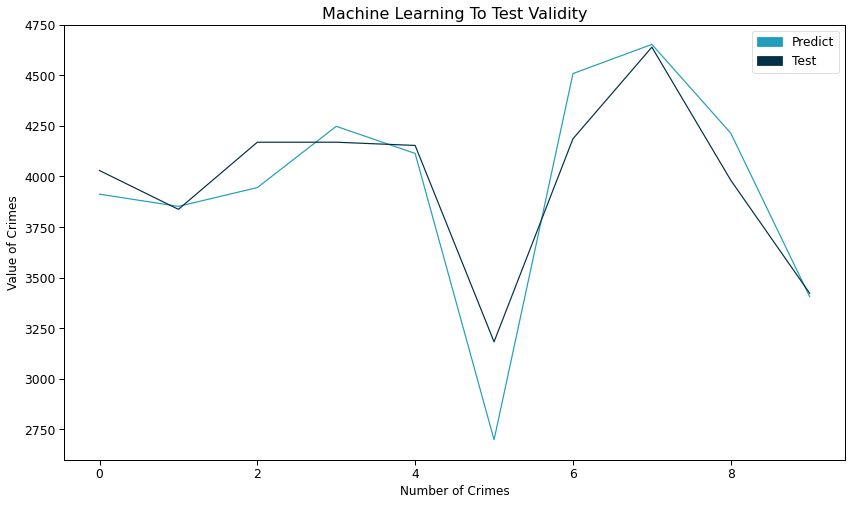

In [591]:
#Test the validity of machine learning model by using Root Mean Squared Error, RMSE
sum_mean=0
for i in range(len(y_pred)):
    sum_mean+=(y_pred[i]-y_test.values[i])**2
sum_erro=np.sqrt(sum_mean/10)  
print ("RMSE by hand:",sum_erro)

plt.figure(figsize=(14, 8))
plt.plot(range(len(y_pred)),y_pred,'#219ebc',label="predict")
plt.plot(range(len(y_pred)),y_test,'#023047',label="test")
plt.legend(loc="upper right")
plt.title("Machine Learning To Test Validity",fontsize=16, color='black')
plt.xlabel("Number of Crimes",fontsize=12, color = 'black')
plt.ylabel('Value of Crimes',fontsize=12, color = 'black')

patch1 = mpatches.Patch(color='#219ebc', label= 'Predict')
patch2 = mpatches.Patch(color='#023047', label= 'Test')
plt.legend(handles=[patch1, patch2])
plt.show()

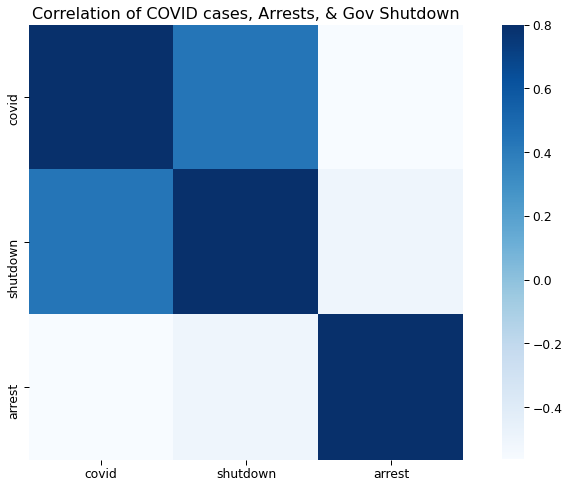

In [583]:
#Multivariate Regression Correlation Table
corrmat = df.drop('crime', axis=1) .corr()
f, ax = plt.subplots(figsize=(14,8))
sns.heatmap(corrmat, vmax=.8, square=True, cmap = "Blues")
ax.set_title("Correlation of COVID cases, Arrests, & Gov Shutdown",fontsize=16, color='black');

In [584]:
#Multivariate Regression Summary Output
from statsmodels.formula.api import ols 
                    
lm = ols('crime ~covid + shutdown + arrest', data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     37.00
Date:                Mon, 30 Nov 2020   Prob (F-statistic):           7.08e-10
Time:                        16:06:54   Log-Likelihood:                -225.67
No. Observations:                  32   AIC:                             459.3
Df Residuals:                      28   BIC:                             465.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1198.0755    398.691      3.005      0.006     381.393    2014.758
covid         -0.1042      0.039     -2.696      0.012      -0.183      -0.025
shutdown    1166.7115    214.922      5.429      0.000     726.464    1606.959
arrest         3.4775      0.438      7.939      0.000       2.580       4.375
==============================================================================
Omnibus:                       10.337   Durbin-Watson:                   2.648
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.020
Skew:                           0.873   Prob(JB):                      0.00405
Kurtosis:                       5.284   Cond. No.                     2.58e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Linear Regression Part Two: 2019/2020 CRIME DIFFERENCE AND 2020 COVID
### 2-1. Simple Linear Regression: 2019/2020 weekly crime differences vs.2020 weekly covid cases
This regression mainly indicates that the relationship between Chicago weekly COVID cases and the percentage differences between Chicago weekly crimes in 2020 and Chicago weekly crimes in 2019 is negative. The relationship coefficient is -0.00756081. When weekly COVID cases increase by 1000, the crime rate goes down which makes the difference between this year and last year's crimes increases by 7.56081%. When COVID cases increase by 2000, the crime rate goes down which makes the difference between this year and last year's crimes increases by 15.12162%.

coefficient matrix:
 [-0.00756081]
linear regression:
 LinearRegression(n_jobs=1)


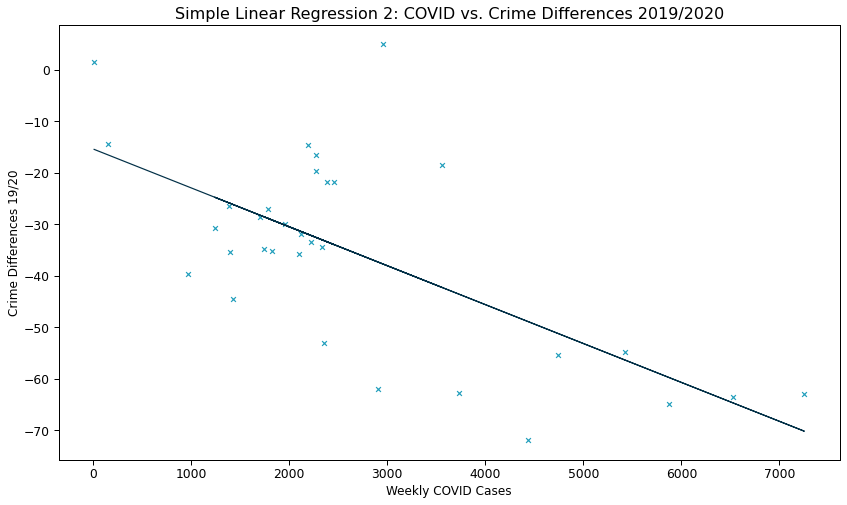

In [646]:
#Simple Linear Regression Visualization

data=pd.read_csv('780-project-machine-learning2.csv')
 
dataMat = np.array(data)
X = dataMat[:,0:1]   
y = dataMat[:,1]
 
model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
model.fit(X, y)  
print('coefficient matrix:\n',model.coef_)
print('linear regression:\n',model)

predicted = model.predict(X)

plt.figure(figsize=(14, 8)) 
plt.scatter(X, y, marker='x', c='#219ebc')
plt.plot(X, predicted,c='#023047')

plt.title("Simple Linear Regression 2: COVID vs. Crime Differences 2019/2020",fontsize=16, color='black')
plt.xlabel("Weekly COVID Cases",fontsize=12, color = 'black')
plt.ylabel("Crime Differences 19/20",fontsize=12, color = 'black')
plt.show()

MSE: 301.939
determinator: -1.135
prediction model is：y=-0.007x-23.562


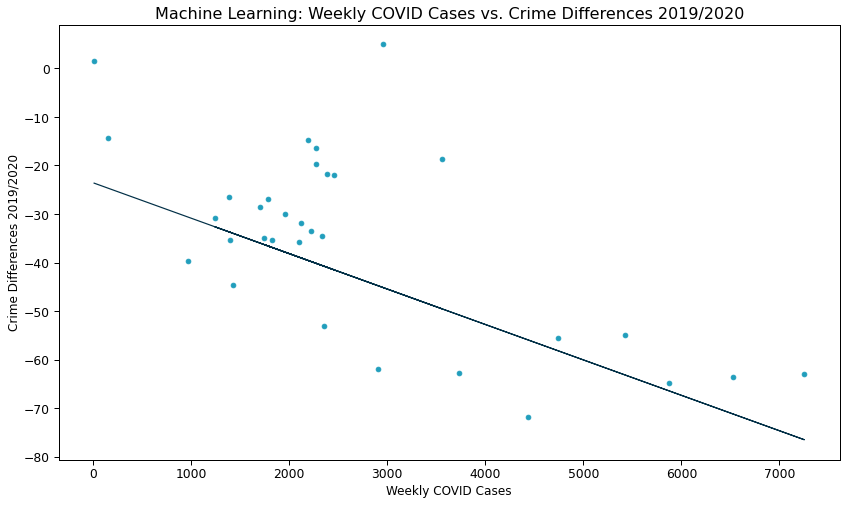

In [645]:
#Machine Learning: Weekly COVID Cases vs. Crime Differences 2019/2020
def linearmodel(data):
	features=['x']
	labels=['y']
	train_data=data[:11]
	test_data=data[11:]
	model=train_model(train_data,features,labels)
	error,score=evaluate_model(model,test_data,features,labels)
	visualize_model(model,data,features,labels,error,score)

def train_model(train_data,features,labels):
	model=linear_model.LinearRegression()
	model.fit(train_data[features],train_data[labels])
	return model

def evaluate_model(model,test_data,features,labels):
	error=np.mean((model.predict(test_data[features])-test_data[labels])**2)
	score=model.score(test_data[features],test_data[labels])
	error=("%.3f" % error[0])
	print('MSE:',error) 
	score=("%.3f" % score)
	print('determinator:',score)
	coef=("%.3f" % model.coef_)
	intercept=("%.3f" % model.intercept_)
	if model.intercept_<0:
		print('prediction model is：y={}x{}'.format(str(coef),str(intercept)))
	else:
		print('prediction model is：y={}x+{}'.format(str(coef),str(intercept)))
	return error,score

def visualize_model(model,data,features,labels,error,score):
	fig=plt.figure(figsize=(14,8))
	ax=fig.add_subplot(111)
	ax.set_xlabel('Weekly COVID Cases',fontsize=12, color = 'black')
	ax.set_ylabel('Crime Differences 2019/2020',fontsize=12, color = 'black')
	ax.set_title("Machine Learning: Weekly COVID Cases vs. Crime Differences 2019/2020", fontsize=16, color='black')
	ax.scatter(data[features],data[labels],color='#219ebc')
	ax.plot(data[features],model.predict(data[features]),color='#023047')
	plt.show()
    
if __name__=='__main__':
	path='780-project-machine-learning2.csv'
	data=pd.read_csv(path)
	linearmodel(data)

### 2-2. Multivariate Regression: 2019/2020 weekly crime differences vs.2020 weekly covid cases & weekly arrest cases & shutdown
According to the regression output, 2019/2020 weekly crime differences = -0.0037*weekly covid cases + 15.2544*shutdown + 0.0956*weekly arrest cases - 93.0493。
The relationship between independent variables and dependent variables in a multivariate regression are all captured by slope coefficients.

However, according to the correlation matrix and the regression summary output generated by Python, the condition number is large, 2.58e+04. This might indicate that there are strong multicollinearity or other numerical problems. Given our datasets only include limited quantiflied or Boolean data dategories that can interact with our dependent variable 2019/2020 weekly crime differences, it's hard to get rid of the multicollinearity issue entirely. This is one limitation of the multivariate regression model. If we had a chance to collect the data by ourselves, we might have pre-determined the data categories that must be included in a multivariate regression, and we might have kept all the independent variables to be highly independent from each others.

In [587]:
#Linear Multivariate Regression
dataPath = r"780-1129-2.csv"  
delivaryData = np.genfromtxt(dataPath,delimiter=',')  

X = delivaryData[:,:-1]  
Y = delivaryData[:,-1]

regr = linear_model.LinearRegression()  

regr.fit(X,Y) 

print("xs' coefficients：",regr.coef_)   
print("intercept：",regr.intercept_) 

xs' coefficients： [-3.74848325e-03  1.52543798e+01  9.56087736e-02]
intercept： -93.04928367194339


In [624]:
#Multivariate Regression Summary Output
from statsmodels.formula.api import ols 

df1=pd.read_csv('780-1129-3.csv')
lm1 = ols('crimedifference ~ covid1 + shutdown1 + arrest1', data=df1).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        crimedifference   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     39.07
Date:                Mon, 30 Nov 2020   Prob (F-statistic):           3.85e-10
Time:                        21:15:49   Log-Likelihood:                -113.61
No. Observations:                  32   AIC:                             235.2
Df Residuals:                      28   BIC:                             241.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -93.0493     12.016     -7.744      0.000    -117.662     -68.436
covid1        -0.0037      0.001     -3.218      0.003      -0.006      -0.001
shutdown1     15.2544      6.477      2.355      0.026       1.986      28.523
arrest1        0.0956      0.013      7.243      0.000       0.069       0.123
==============================================================================
Omnibus:                        2.171   Durbin-Watson:                   2.294
Prob(Omnibus):                  0.338   Jarque-Bera (JB):                1.028
Skew:                          -0.179   Prob(JB):                        0.598
Kurtosis:                       3.802   Cond. No.                     2.58e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### What are the top 5 of crime type in 2019 - 2020 and how do the percentages of those crimes change?
The top 5 crime types remained the same in 2019 and 2020 and are: Theft, Battery, Criminal Damege, Assault, and Deceptive Practice. Interestingly, the number of crimes among different crime types decreased over time. In 2020, since COVID-19 started, theft has been decreasing by 32.69% which is the largest decrease among the top 5 crime types. Deceptive Practice has been decreasing by 24.14% which is the second biggest decrease. The third is battery(-15.07%), the fourth is assault(-11.34%) and the fifth is criminal damage(-6.43%). The biggest impact of COVID-19 on daily life is that it reduced the frequency and time spent going out. We can see that under this condition, the theft, which is often related to going out has the biggest decrease among the top 5 crime types.

In [596]:
crime_19 = crime_clean[(crime_clean['year'] == 2019)]
crime_20 = crime_clean[(crime_clean['year'] == 2020)]
a = crime_19.groupby(crime_19['primary_type'])['unique_key'].count()
b = crime_20.groupby(crime_20['primary_type'])['unique_key'].count()
c = pd.merge(a,b,on='primary_type',suffixes=['_19','_20'])
c['percentage_change'] = (c['unique_key_20'] - c['unique_key_19']) / c['unique_key_19'] * 100
c.sort_values('unique_key_20', ascending = False)[:5]

,unique_key_19,unique_key_20,percentage_change
primary_type,,,
BATTERY,42013,35680,-15.073906
THEFT,52097,35068,-32.687103
CRIMINAL DAMAGE,22707,21248,-6.425331
ASSAULT,17603,15607,-11.338976
DECEPTIVE PRACTICE,14532,11024,-24.139829


### Where did crimes happen most in 2019 - 2020 and how did frequencies of locations change?
The top 5 locations that had the mose crimes in 2019 and 2020 are on or near a street, residence, apartment, sidewalk, or small retail store. The number of crimes happening among the different location are decreasing over time. In 2020, due to COVID-19, crimes on or near sidewalks have been decreasing by 33.10% which is the largest decrease among the top 5 locations. The crimes in or near small retail stores have been decreasing by 21.05% which is the second largest decrease. The third is residence(-15.70%), the fourth is on or near the street(-11.60%) and the fifth is apartments(-0.39%). Due to the outbreak of COVID-19, people are staying indoors most of the time, which reduces the number of crimes that occur outdoors or in public places such as sidewalks, small retail stores and streets. Moreover, COVID-19 requires social distancing between people and reduced gatherings which may also be the reason for the decline in crime rates in residence and apartment locations.

In [597]:
crime_19 = crime_clean[(crime_clean['year'] == 2019)]
crime_20 = crime_clean[(crime_clean['year'] == 2020)]
a = crime_19.groupby(crime_19['location_description'])['unique_key'].count()
b = crime_20.groupby(crime_20['location_description'])['unique_key'].count()
c = pd.merge(a,b,on='location_description',suffixes=['_19','_20'])
c['percentage_change'] = (c['unique_key_20'] - c['unique_key_19']) / c['unique_key_19'] *100
c.sort_values('unique_key_20', ascending = False)[:5]

,unique_key_19,unique_key_20,percentage_change
location_description,,,
STREET,48046,42475,-11.595138
RESIDENCE,36166,30488,-15.699829
APARTMENT,29081,28967,-0.392009
SIDEWALK,17561,11748,-33.101760
SMALL RETAIL STORE,5778,4562,-21.045344


### How did the number of crimes change by the shutdown?
We find out that after the shutdown in Chicago, the number of crimes didn't have a big increase or decrease except the last day of May. The overall crimes has increase a little bit after April 7th which is the day that Chicago city shutdown.

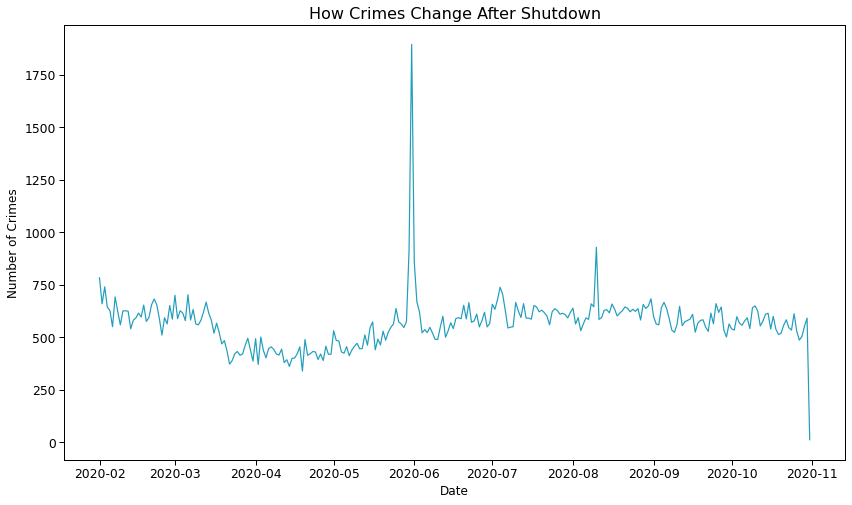

In [598]:
crime_shutdown = crime_clean[(crime_clean['date'] >='2020-02-01') & (crime_clean['date'] <= '2020-10-31')]
variable = ['unique_key','date']
a = crime_shutdown[variable]
a = a.groupby(a['date'].dt.date)['unique_key'].count()
plt.figure(figsize=(14,8))
plt.title('How Crimes Change After Shutdown',fontsize=16, color='black')
plt.xlabel('Date',fontsize=12, color = 'black')
plt.ylabel('Number of Crimes',fontsize=12, color = 'black')
plt.plot(a, '#219ebc')
plt.show()

### How did the number of crimes change by the shutdown - BATTERY?
We can find out that after the day of shutdown, the crime number of BATTERY has been increase in Chicago compare with the number before the shutdown.

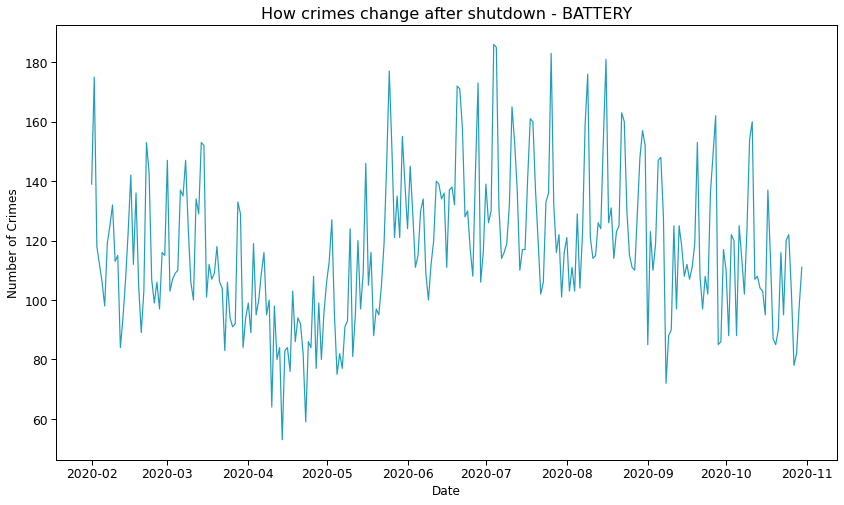

In [599]:
crime_shutdown = crime_clean[(crime_clean['date'] >='2020-02-01')& (crime_clean['date'] <= '2020-10-31') & (crime_clean['primary_type'] == 'BATTERY')]
variable = ['unique_key','date','primary_type']
a = crime_shutdown[variable]
a = a.groupby(a['date'].dt.date)['unique_key'].count()
plt.figure(figsize=(14,8))
plt.title('How crimes change after shutdown - BATTERY',fontsize=16, color='black')
plt.xlabel('Date',fontsize=12, color = 'black')
plt.ylabel('Number of Crimes',fontsize=12, color = 'black')
plt.plot(a, '#219ebc')
plt.show()

### How did the number of crimes change by the shutdown - THEFT?
We can find out that after the day of shutdown, the crime number of THEFT has been decrease at first, then it began to rise in June.

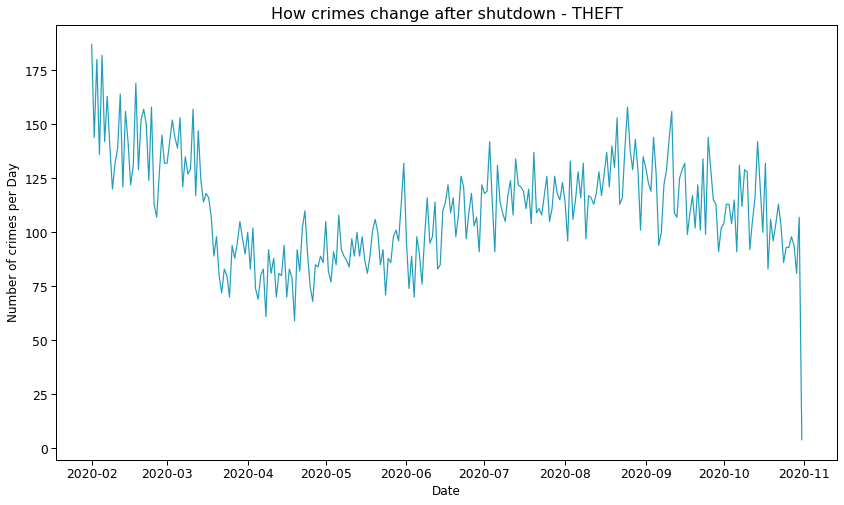

In [621]:
crime_shutdown = crime_clean[(crime_clean['date'] >='2020-02-01')& (crime_clean['date'] <= '2020-10-31') & (crime_clean['primary_type'] == 'THEFT')]
variable = ['unique_key','date','primary_type']
a = crime_shutdown[variable]
a = a.groupby(a['date'].dt.date)['unique_key'].count()
plt.figure(figsize=(14,8))
plt.title('How crimes change after shutdown - THEFT',fontsize=16, color='black')
plt.xlabel('Date',fontsize=12, color = 'black')
plt.ylabel('Number of crimes per Day',fontsize=12, color = 'black')
plt.plot(a, '#219ebc')
plt.show()

### How did the number of crimes change by the shutdown - CRIMINAL DAMAGE?
We can find out that after the day of shutdown, the crime number of CRIMINAL DAMAGE doesn't change much in Chicago compare with the number before the shutdown.

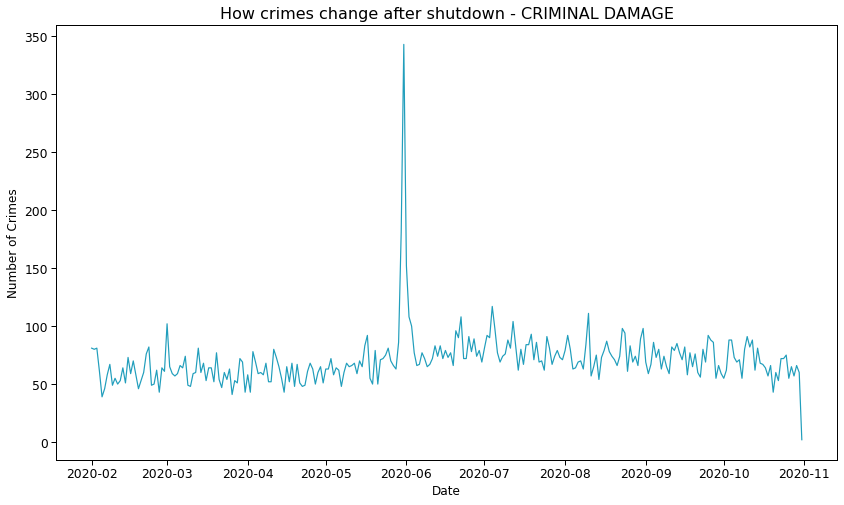

In [603]:
crime_shutdown = crime_clean[(crime_clean['date'] >='2020-02-01')& (crime_clean['date'] <= '2020-10-31') & (crime_clean['primary_type'] == 'CRIMINAL DAMAGE')]
variable = ['unique_key','date','primary_type']
a = crime_shutdown[variable]
a = a.groupby(a['date'].dt.date)['unique_key'].count()
plt.figure(figsize=(14,8))
plt.title('How crimes change after shutdown - CRIMINAL DAMAGE',fontsize=16, color='black')
plt.xlabel('Date',fontsize=12, color = 'black')
plt.ylabel('Number of Crimes',fontsize=12, color = 'black')
plt.plot(a, '#219ebc')
plt.show()

### How many people got arrested in 2019 and 2020 and how did the arrested rate change?
Between 2019 and 2020 the arrested rate for crimes went down. COVID-19 caused lots of changes in Chicago including a police strike and the decrease in arrested rates. In order to make the conclusion that the arrested rate decreased due to COVID-19 we need to eliminate some other factors that may also cause the arrested rate to decrease such as the overall crime numbers decreasing and an increase in crimes which may not be very serious and often don't get arrested. Using the queries below, we can eliminate these factors because although primary types of crimes change and arrested rates change for all primary types that decreased, the arrested rate change was much higher than the primary type of crime change indicating that if two people made the same mistake in 2019 and 2020, there is a greater chance of being arrested in 2019. This is caused by COVID-19 and the reduced number of police. Another reason for the disproportionate decrease in arrest rates is nearly 16% of Illinois COVID-19 cases were linked to outbreaks from Chicago jail so the government reduced the arrested rate to avoid the spread of COVID-19 in the prison according to a study. 

Firstly, checking the arrested rate for recent year. We can see there is a big drop from 2019 to 2020. So we can exclude the time factor and just compared our 2020 datasets with 2019. 

note: **crime_1620** is the clean crime dataset from 2016 to 2020.

In [604]:
crime_1620 = crime_clean[(crime_clean['year']>=2016) & (crime_clean['year']<=2020)]
crime_1620.groupby('year')['arrest'].sum()/crime_1620.groupby('year')['arrest'].count() *100

year
2016    20.149600
2017    19.870445
2018    20.150801
2019    21.734780
2020    16.113980
Name: arrest, dtype: float64

Comparing the arrested rate for different months in 2019 and 2020.

As you can see in the graph below, the arrest rate for 2020 is much lower than 2019 based on each month except for January and February which did not have covid cases. The overall trend for each month is similar between 2019 and 2020 except for April and May, there was a big drop from March to April and big increased from April to May. The reason for this trend is that March to April was the beginning of the Covid19, and many police officers went on strike because they were afraid of getting Covid-19. Also, when I checked the news on city of Chicago, there was an announcement of shutting down on April 7th. So that's also the reason for a drop of arrested rate in April. From April to May, the reason for the increasing was that protest for Black live matter, there were more crime cases happened and the government increased police force to control the procession.

,arrest_rate19,arrest_rate20
date,,
1,22.985151,22.887324
2,22.919972,22.964405
3,23.418282,18.587248
4,22.039253,11.182235
5,21.754833,14.529075
6,20.908432,13.014409
7,21.185652,13.742918
8,21.406803,14.594345
9,20.985328,14.367586


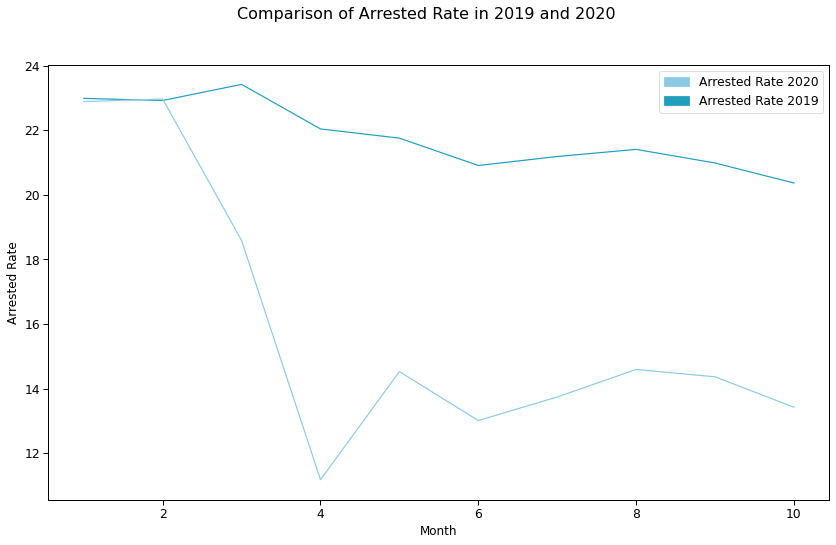

In [606]:
crime_19 = crime_clean[(crime_clean['year'] == 2019)]
crime_20 = crime_clean[(crime_clean['year'] == 2020)]
a = crime_19.groupby(crime_19['date'].dt.month)['arrest'].sum()/crime_19.groupby(crime_19['date'].dt.month)['arrest'].count() *100
b = crime_20.groupby(crime_20['date'].dt.month)['arrest'].sum()/crime_20.groupby(crime_20['date'].dt.month)['arrest'].count() *100
c = pd.merge(a,b,on='date',suffixes=['_rate19','_rate20'])
visual = c[['arrest_rate19','arrest_rate20']]
plt.figure(figsize=(14,8))
plt.ylabel('Arrested Rate',fontsize=12, color = 'black')
plt.xlabel('Month',fontsize=12, color = 'black')
plt.suptitle('Comparison of Arrested Rate in 2019 and 2020', fontsize=16, color='black')
plt.yscale('linear')
line1 = mpatches.Patch(color='#219ebc',label='Arrested Rate 2019')
line2 = mpatches.Patch(color='#8ecae6',label='Arrested Rate 2020')
plt.legend(handles=[line2,line1])
hue_colors = {'#8ecae6','#219ebc','#023047'}
sns.set_palette(hue_colors)
display(plt.plot(visual),c)

Comparison of Covid cases and arrested number for 2020. There is no significant relationship between Covid cases and arrested number based on the table and graph below. 

,Cases___Total,arrest
1,NaN,4485
2,NaN,4129
3,4414.0,3055
4,21571.0,1415
5,21354.0,2516
6,6308.0,2258
7,8272.0,2644
8,9983.0,2844
9,9156.0,2507
10,26402.0,2360


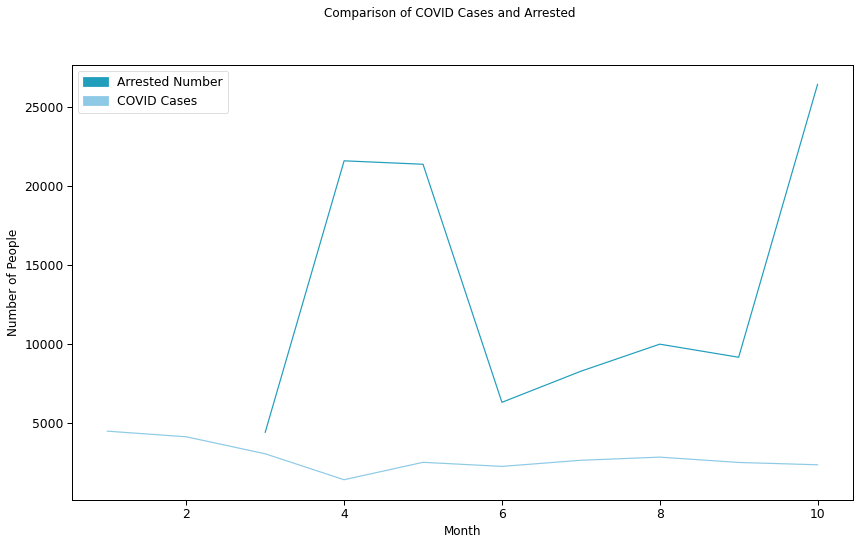

In [608]:
covid = covid_month.to_frame()
arrest = crime_20.groupby(crime_20['date'].dt.month)['arrest'].sum().to_frame()
arrest_vs_covid = pd.concat([covid,arrest], axis=1)
visual0 = arrest_vs_covid[['Cases___Total','arrest']]
plt.figure(figsize=(14,8))
plt.ylabel('Number of People',fontsize=12, color = 'black')
plt.xlabel('Month',fontsize=12, color = 'black')
plt.suptitle('Comparison of COVID Cases and Arrested')
plt.yscale('linear')
x = mpatches.Patch(color='#219ebc',label='Arrested Number')
y = mpatches.Patch(color='#8ecae6',label='COVID Cases')
plt.legend(handles=[x,y])
hue_colors = {'#8ecae6','#219ebc','#023047'}
sns.set_palette(hue_colors)
display(plt.plot(visual0),arrest_vs_covid)

Arrest changes and crime changes in 2019 and 2020 based on each primary type.

In [609]:
d = (crime_20.groupby('primary_type')['arrest'].sum() - crime_19.groupby('primary_type')['arrest'].sum())/crime_19.groupby('primary_type')['arrest'].sum() *100
e = (crime_20.groupby('primary_type')['unique_key'].count() - crime_19.groupby('primary_type')['unique_key'].count())/crime_19.groupby('primary_type')['unique_key'].count()*100
f = pd.merge(d,e,on='primary_type')
f.sort_values('arrest')[:10]

,arrest,unique_key
primary_type,,
GAMBLING,-83.823529,-83.823529
STALKING,-71.428571,-17.708333
CRIMINAL SEXUAL ASSAULT,-69.230769,-28.093159
SEX OFFENSE,-61.151079,-27.557604
DECEPTIVE PRACTICE,-59.553696,-24.139829
INTERFERENCE WITH PUBLIC OFFICER,-58.494957,-56.564141
PUBLIC PEACE VIOLATION,-56.521739,-11.852963
NARCOTIC VIOLATION,-53.081712,-53.064717
PROSTITUTION,-52.836879,-52.482270


Since October is the month of the US presidential election, there were lots of processions to increase the crime number and covid confirmed cases, so the tables below are comparing September and October's crime and arrested based on different crime types.

The table below shows that the different crimes and different arrest between September and October 2020. As you can see from the table, the overall differences in crime number is larger than differences in arrest number which means there were more crime in October but the arrest differences were less than crime differences even in some crime types the arrest number decreased while crime cases increased. But there is a different crime type which is public peace violation which has larger differences_arrest than differences_crime which means more probability of people being arrested on October based on public peace violation. 

In [610]:
crime9 = crime_20[(crime_20['date'].dt.month == 9)]
crime10 = crime_20[(crime_20['date'].dt.month == 10)]
a = crime9.groupby('primary_type')['arrest'].sum()
b = crime10.groupby('primary_type')['arrest'].sum()
c = pd.merge(a,b,on='primary_type',suffixes=['_9','_10'])
c['differences_arrest'] = c['arrest_10'] - c['arrest_9']
#c.sort_values('differences_arrest',ascending=False)[:5]
e = crime9.groupby('primary_type')['unique_key'].count()
f = crime10.groupby('primary_type')['unique_key'].count()
g = pd.merge(e,f,on='primary_type',suffixes=['_9','_10'])
g['differences_crime'] = g['unique_key_10'] - g['unique_key_9']
#g.sort_values('differences_crime',ascending=False)[:10]
h = pd.merge(g,c,on='primary_type')
x = h.sort_values('differences_crime',ascending=False)[:10]
x[['differences_crime','differences_arrest']][:10]

,differences_crime,differences_arrest
primary_type,,
DECEPTIVE PRACTICE,590,-26
NARCOTIC VIOLATION,87,87
MOTOR VEHICLE THEFT,63,2
BURGLARY,24,-2
INTERFERENCE WITH PUBLIC OFFICER,18,15
ROBBERY,16,-24
CRIMINAL SEXUAL ASSAULT,10,-1
OFFENSE INVOLVING CHILDREN,4,-4
OBSCENITY,2,2


In addtion, the table below shows the arrest rate in September and October and the differences between them. Obviously, the arrest rate in October was much higher in public peace violation than September. 

In [611]:
arrest9 = ((crime9.groupby('primary_type')['arrest'].sum()/crime9.groupby('primary_type')['unique_key'].count())*100).to_frame()
arrest10 = ((crime10.groupby('primary_type')['arrest'].sum()/crime10.groupby('primary_type')['unique_key'].count())*100).to_frame()
arrest = pd.merge(arrest9,arrest10,on='primary_type',suffixes=['rate_9','rate_10'])
arrest['difference_rate'] = arrest['0rate_10'] - arrest['0rate_9']
arrest.sort_values('difference_rate',ascending=False)[:5]

,0rate_9,0rate_10,difference_rate
primary_type,,,
PUBLIC PEACE VIOLATION,35.384615,52.238806,16.854191
WEAPONS VIOLATION,61.910377,63.125763,1.215386
OTHER OFFENSE,11.621094,12.180747,0.559653
CRIMINAL TRESPASS,35.326087,35.668790,0.342703
CRIMINAL DAMAGE,3.707136,3.958530,0.251393


### What primary types changed the most and how does that affect the domestic violence rate?
We find that between 2019 and 2020, the primary types of crime that had the greatest increases were Arson, Homicide, Weapons Violations, and Motor Vehicle Theft. While overall crime rates went down, these specific types of crime increased by 63.2%, 53.3%, 25.84%, and 7.24% respectively. We also wanted to explore how COVID-19 affected rates of domestic violence and found that domestic violence overall increased by 3% from 2019 to 2020 even though the actual amount of domestic violence crimes decreased by 8%. 

In [612]:
crime_19 = crime_clean[(crime_clean['year'] == 2019) & (crime_1920['month']>= 1) & (crime_1920['month']<= 10)]
crime_20 = crime_clean[(crime_clean['year'] == 2020) & (crime_1920['month']>= 1) & (crime_1920['month']<= 10)]
a = crime_19.groupby(crime_19['primary_type'])['unique_key'].count()
b = crime_20.groupby(crime_20['primary_type'])['unique_key'].count()
c = pd.merge(a,b,on='primary_type',suffixes=['_19','_20'])
c['percentage_change'] = (c['unique_key_20'] - c['unique_key_19']) / c['unique_key_19'] * 100
c.sort_values('percentage_change', ascending = False)[:10]

,unique_key_19,unique_key_20,percentage_change
primary_type,,,
ARSON,302,493,63.245033
HOMICIDE,437,670,53.318078
WEAPONS VIOLATION,5569,7008,25.839468
MOTOR VEHICLE THEFT,7516,8060,7.237892
ROBBERY,6582,6530,-0.790033
INTIMIDATION,147,142,-3.401361
OBSCENITY,47,45,-4.255319
BURGLARY,8015,7545,-5.864005
CRIMINAL DAMAGE,22707,21248,-6.425331


In [618]:
crime_19 = crime_clean[(crime_clean['year'] == 2019) & (crime_1920['month']>= 1) & (crime_1920['month']<= 10)]
crime_20 = crime_clean[(crime_clean['year'] == 2020) & (crime_1920['month']>= 1) & (crime_1920['month']<= 10)]
a = crime_19.groupby(crime_19['domestic'])['unique_key'].count()
b = crime_20.groupby(crime_20['domestic'])['unique_key'].count()
c = pd.merge(a,b,on='domestic',suffixes=['_19','_20'])
d = c['percentage_change'] = (c['unique_key_20'] - c['unique_key_19']) / c['unique_key_19']*100
c.sort_values('percentage_change', ascending = False)[:10]

crime_vs_covid_m.columns = ['Covid-19 Cases', 'Crimes-Cases 19', 'Crimes-Cases 20', 'Diff Crimes 19/20']


In [614]:
crime_19 = crime_clean[(crime_clean['year'] == 2019) & (crime_1920['month']>= 1) & (crime_1920['month']<= 10)]
crime_20 = crime_clean[(crime_clean['year'] == 2020) & (crime_1920['month']>= 1) & (crime_1920['month']<= 10)]
dom_19 = crime_19['domestic'].sum()
dom_20 = crime_20['domestic'].sum()
crime_tot_19 = crime_19['unique_key'].count()
crime_tot_20 = crime_20['unique_key'].count()
percent_dom_crime_19 = dom_19/crime_tot_19
percent_dom_crime_20 = dom_20/crime_tot_20
data = [dom_19, crime_tot_19, percent_dom_crime_19], [dom_20, crime_tot_20, percent_dom_crime_20]
headers = ['Count Domestic Crime', 'Count Total Crime', 'Percent Domestic Crime of Total']
print(pd.DataFrame(data, data, headers))

                                      Count Domestic Crime  Count Total Crime  \
(36465, 218875, 0.1666019417475728)                  36465             218875   
(33251, 175084, 0.18991455529917067)                 33251             175084   

                                      Percent Domestic Crime of Total  
(36465, 218875, 0.1666019417475728)                          0.166602  
(33251, 175084, 0.18991455529917067)                         0.189915  


The above table shows that the percent of total crimes that are domestic crimes increased from 2019-2020. 

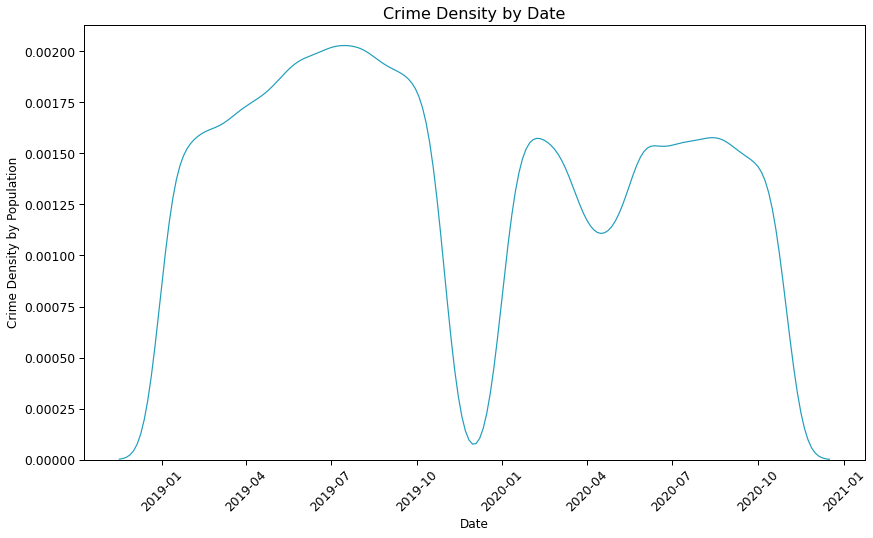

In [615]:
plt.figure(figsize=(14, 8))
sns.kdeplot(crime_1920['date'])
plt.xticks(rotation = 45)
plt.title('Crime Density by Date',fontsize=16, color='black')
plt.xlabel('Date',fontsize=12, color = 'black')
plt.ylabel('Crime Density by Population',fontsize=12, color = 'black')
hue_colors = {'#8ecae6','#219ebc','#023047'}
sns.set_palette(hue_colors)

The above plot shows the crime by population over the 2019-2020 timeline. It shows how the crimes overall was higher thorughout the year of 209 as well as the clear dip in crime around March/April due to Covid 19. 

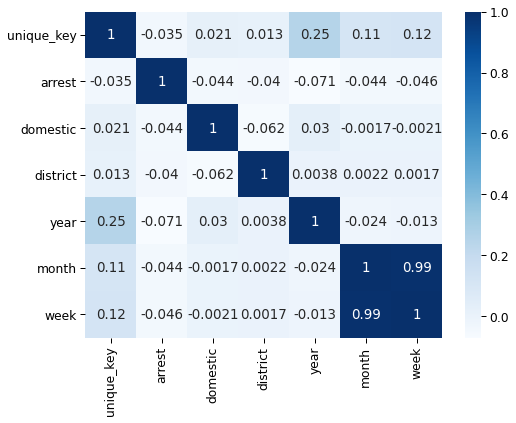

In [616]:
plt.figure(figsize=(8,6))
sns.set_context('paper',font_scale=1.4)

# crime_1920
crime_mx = crime_1920.corr()
crime_mx
sns.heatmap(crime_mx, annot = True, cmap = 'Blues');

The above heatmap shows the impact of specific variables on other variables. For example, district has about a -6% impact on the domestic value. 

### How many crimes happened in each month on average in the last 6 years and 2020 and how many people got arrested?

In [617]:
crime_1420 = crime_clean[(crime_clean['year']>=2014) & (crime_clean['year']<=2020)]
a = round((crime_1420.groupby(crime_1420['date'].dt.month)['unique_key'].count()/6),0).to_frame()
b = round((crime_1420.groupby(crime_1420['date'].dt.month)['arrest'].sum()/6),0).to_frame()
c = pd.merge(a,b,on='date')
c

,unique_key,arrest
date,,
1,23824.0,5610.0
2,20955.0,5249.0
3,24006.0,5859.0
4,23630.0,5427.0
5,26777.0,6058.0
6,26857.0,5741.0
7,28215.0,6007.0
8,28196.0,5913.0
9,25997.0,5499.0


### Did the number of crime cases change in 2020 compared to the average number of crimes in the last six years?
Crime cases have a big drop from 2019 to 2020.

In [619]:
crime_1420.groupby('year')['unique_key'].count()

year
2014    233506
2015    222334
2016    226337
2017    225078
2018    224800
2019    218875
2020    175084
Name: unique_key, dtype: int64

### Additional Points of interest and exploration
Within the last two years, the 2 out of 5 of the top crime days happened on 5/30 and 5/31. 
This is of note because within the week of 5/29 - 6/04 there were 413 complaints against the Chicago
police department directly related to the Black Lives Matter protests and because public peace violation is the second highest reason for arrest on those 5/30 nd 5/31. Within the week of 5/29 - 6/04, Public Peace Violations made up 445 crimes. The relationship between this information points to the fact that data can have bias based on who is enter and configuring the data. The first table shows that the public peace violation was the second highest type of crime on 5/30 and 5/31, while the seond table shows an aggregate of the all the public peace violation crimes between the week of 5/29-6/04. 

##### What were the top 5 dates that had the highest crimes in 2019 - 2020?

In [620]:
a = crime_1920.groupby(crime_1920['date'].dt.date)['unique_key'].count()
a.sort_values(ascending=False)[:5].to_frame()

,unique_key
date,
2020-05-31,1894
2019-01-01,1009
2020-08-10,928
2020-05-30,918
2019-06-01,899
